## Detection of monosynapic connections
A major advantage of single unit recordings is that we can detect if they are synaptically connected. There is a well-established procedure for assessing a single synaptic linkage from one neuron onto another, referred to as a monosynaptic connection. Polysynaptic connections, whereby one neuron influences another via a chain of synapses, is harder to detect if we have not recorded from the entire chain. However, if enough neurons are sampled from complex networks of connections can be uncovered and related back to what these neurons encode. This indicates how a microcircuit's structure implements function.

This tutorial covers the detection of monosynaptic connections and creation of a connection matrix.

In [1]:
import pynapple as nap
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mimo_pack.fileio.loadphy import as_pynapple

### Load spiking data

In [2]:
phy_dir = 'D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\kilosort4\\'
spks = as_pynapple(phy_dir, suffix='_sas')

Index    rate
-------  --------
0        1.68213
1        0.6188
2        5.65923
3        4.07561
4        14.96972
5        0.10543
6        0.23481
...      ...
764      10.12453
765      8.05819
766      15.21623
767      14.28832
768      9.72477
769      8.24472
770      5.49346
           SASLabel
cluster_id         
0             Noise
1                SU
2                SU
3                MU
4                MU
...             ...
766              SU
767              SU
768              MU
769              MU
770              SU

[701 rows x 1 columns]


QA on units. To start, just remove those that are not SU

In [3]:
spks = spks.getby_category('SASLabel')['SU']


### Calculate cross-correlation
To determine if a monosynaptic connection is present, we calculate the cross-correlation between single units. One of the units is designated the reference and the other the target. A histogram is constructed of the spike times from the target with respect to the spike times of the reference. If there is an excess of target spikes following a spike from the reference, this could indicate an excitatory synaptic connection.

The pynapple package provides an optimized algorithm for calculating cross-correlation functions.

In [4]:
bin_dur = 0.0005 # in seconds, 0.5 ms
win_dur = 0.01 # in seconds, 10 ms

cc_func = lambda x: nap.compute_crosscorrelogram(x,binsize=bin_dur,windowsize=win_dur,reverse=True)
spks_cc = cc_func(spks)

Pynapple returns the CC as a dataframe like object with each row a different time point, and each column a unique pair. A multilevel index is used for accessing the pairs. It is expressed as a tuple of 2 values, with form *(reference, target)*. Reference is the unit who spikes at time 0 ms, while target is the unit whose firing rate is being calculated relative to the spiking of the reference unit.

Here is how to pull out information from the cross-correlation object returned by pynapple:

In [5]:
# Get the time points of the CC
cc_tpts = spks_cc.index.values
print('The time points look like this:\n{}'.format(cc_tpts))

The time points look like this:
[-0.01   -0.0095 -0.009  -0.0085 -0.008  -0.0075 -0.007  -0.0065 -0.006
 -0.0055 -0.005  -0.0045 -0.004  -0.0035 -0.003  -0.0025 -0.002  -0.0015
 -0.001  -0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025  0.003
  0.0035  0.004   0.0045  0.005   0.0055  0.006   0.0065  0.007   0.0075
  0.008   0.0085  0.009   0.0095  0.01  ]


In [6]:
# List all the pairs
cc_pairs = spks_cc.columns.values.tolist()

print('Number of pairs: {}'.format(len(cc_pairs)))

Number of pairs: 53956


### Examine CCs
Cross-correlation fuctions are often visualized as bar charts. Learning how to interpret these is an essential skill for an electrophysiologist.

In [8]:
# function to plot a cross-correlation
def cc_plot(cc, ax=None, labels=True): 
    # cc is a series selected from spks_cc, e.g. spks_cc[(0,1)] for the cc between unit 0 and 1
    t_pts = cc.index.values*1000
    cc_vals = cc.values
    dt = t_pts[1]-t_pts[0]
    if ax is None:
        fig, ax = plt.subplots()
    ax.grid()
    ax.bar(t_pts,cc_vals,width=dt,bottom=0)
    ax.set_xlim((t_pts[0],t_pts[-1]))
    ax.set_title(cc.name)
    if labels:
        ax.set_xlabel('Time from reference spike (ms)')
        ax.set_ylabel('Normalized FR (FR / mean_FR)')
    return ax

Here we will plot a few example pairs that highlight how to interpret CC.

c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


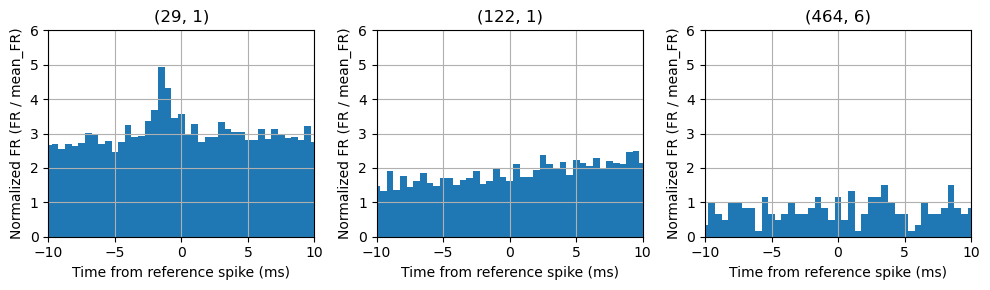

In [9]:
# Monosynaptic CCs vs non-monosynaptic CCs
fig, ax = plt.subplots(1,3)
cc_plot(spks_cc[cc_pairs[11]],ax=ax[0])
cc_plot(spks_cc[cc_pairs[44]],ax=ax[1])
cc_plot(spks_cc[cc_pairs[1160]],ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()

### Statistical testing of connections
A common, but computationally expensive, approach to testing the significance of monosynaptic CCs is to calculate surrogates using randomly jittered spike trains. To jitter, shift each spike in time by a random amount. If you jitter the spike times in a window of ~2 ms, calculate its CC with another unit, and repeat this thousands of times, you get a distribution of CCs that capture slow covarition in spiking activity, but eliminates fast interactions like those found between monosynaptically connected pairs. Using this distribution of CCs, you can measure the probability that the observed CC would have occured. If that probability is below some cutoff, say 0.01, then the CC is judged significant.

In [10]:
jit_max = 0.002 # in seconds, 2 ms
jit_num = 100 # number of jittered CCs to calculate 
cc_null_dist = np.zeros((*spks_cc.values.shape, jit_num))

for i in tqdm(range(jit_num)):
    # kept tsupport only because end of session is 'blank'
    spks_jit = nap.jitter_timestamps(spks, max_jitter=jit_max,keep_tsupport=True)
    spks_cc_jit = cc_func(spks_jit)
    cc_null_dist[:,:,i] = spks_cc_jit.values

null_ci = np.percentile(cc_null_dist,q=[0.5,50,99.5],axis=2)

100%|██████████| 100/100 [9:11:59<00:00, 331.19s/it] 


In [11]:
# function to plot cross-correlation with null confidence intervals
def cc_ci_plot(cc, ci, **kwargs):
    curr_ci = null_ci[:,:,cc_pairs.index(cc.name)]
    t_pts = cc.index.values*1000
    ax = cc_plot(cc, **kwargs)
    ax.fill_between(t_pts,curr_ci[0,:],curr_ci[2,:],alpha=0.2,color='k')
    ax.plot(t_pts,curr_ci[1,:],color='k',linestyle=':')
    ax.plot(t_pts,curr_ci[0,:],color='b',alpha=0.7)
    ax.plot(t_pts,curr_ci[2,:],color='r',alpha=0.7)


Let's replot the CCs from above, but now with the confidence intervals for our surrogate distributions overlaid on top.

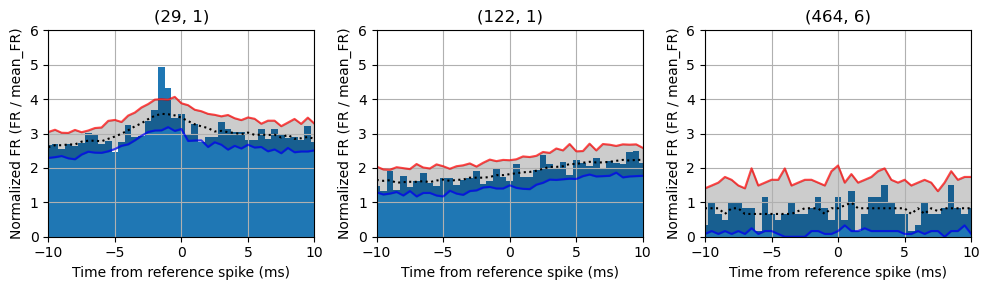

In [12]:
# Monosynaptic CCs vs non-monosynaptic CCs
fig, ax = plt.subplots(1,3)
cc_ci_plot(spks_cc[cc_pairs[11]],null_ci,ax=ax[0])
cc_ci_plot(spks_cc[cc_pairs[44]],null_ci,ax=ax[1])
cc_ci_plot(spks_cc[cc_pairs[1160]],null_ci,ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()


### Building a connection matrix

In [13]:
# determine if CC is significant and its weight
def cc_sig(cc_vals, cc_ci):
    # cc_vals is half the cc (pos or neg lag side), and always starts at 0 lag
    # cc_ci is the lower, middle, and upper null percentiles for the corresponding cc_vals
    cc_dev = cc_vals-cc_ci[1,:]
    max_ind = np.argmax(np.abs(cc_dev))

    # determine if maximal deviation is significant
    if cc_vals[max_ind]>cc_ci[2,max_ind]:
        cc_dev_sig = (cc_vals-cc_ci[2,:])>0
    elif cc_vals[max_ind]<cc_ci[0,max_ind]:
        cc_dev_sig = (cc_vals-cc_ci[0,:])<0
    else:
        return 0 # exit if max deviation is within null CI

    # determine if maximal deviation does not overlap zero lag and is long enough
    # get left edge of significant region
    l_edge = max_ind
    for x in range(max_ind,0,-1):
        l_edge = x
        if not cc_dev_sig[x-1]:
            break
    
    # get right edge of significant region
    r_edge = max_ind
    for x in range(max_ind,cc_vals.size-1):
        r_edge = x
        if not cc_dev_sig[x+1]:
            break
    
    # if sig peak overlaps with 0 time lag, then no connection
    if l_edge == 0:
        return 0

    
    # if sig peak is shorter than 1ms or longer than 4 ms, then no connection
    peak_dur = ((r_edge-l_edge)+1)*bin_dur
    if (peak_dur<0.001) or (peak_dur>0.004):
        return 0
    
    # connection passed all tests and is significant, return weight
    return 100*cc_dev[max_ind]/cc_ci[1,max_ind]


In [33]:
# create connection matrix
num_units = len(spks)

# list all unit ids
conn_mat = pd.DataFrame(np.zeros((num_units, num_units)), index=spks.index, columns=spks.index)
sig_dict = {'pre_id': [], 'post_id': [], 'w': [], 'cc': []}


for ind, pair in enumerate(cc_pairs):
    curr_ci = null_ci[:,:,ind]
    curr_cc = spks_cc[pair]
    z_lag_ind = np.argmin(np.abs(curr_cc.index.values)) # found closest to zero in case lag not exactly zero

    # evaluate positive lag, reference -> target
    w_r2t = cc_sig(curr_cc.values[z_lag_ind:], curr_ci[:,z_lag_ind:])
    conn_mat.loc[pair[0],pair[1]] = w_r2t
    sig_dict['pre_id'].append(pair[0])
    sig_dict['post_id'].append(pair[1])
    sig_dict['w'].append(w_r2t)
    sig_dict['cc'].append(curr_cc.values)
    

    # evaluate negative lag, target -> reference
    w_t2r = cc_sig(curr_cc.values[z_lag_ind::-1], curr_ci[:,z_lag_ind::-1])
    conn_mat.loc[pair[1],pair[0]] = w_t2r
    sig_dict['pre_id'].append(pair[1])
    sig_dict['post_id'].append(pair[0])
    sig_dict['w'].append(w_t2r)
    sig_dict['cc'].append(curr_cc.values[::-1])


In [99]:
sig_df.to_pickle("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\cc.pkl")

In [100]:
# read sig_df from pickle
sig_df2 = pd.read_pickle("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\cc.pkl")

In [101]:
sig_df2

,pre_id,post_id,w,cc,cluster_id_pre,halfwidth_pre,firing_rate_pre,peak_pre,x_pre,y_pre,...,halfwidth_post,firing_rate_post,peak_post,x_post,y_post,unit_type_post,conn_dist,conn_dist_cat,conn_type,conn_sign
0,2,1,0.0,"[0.8456689813849999, 0.8879524304542499, 0.782...",2,0.233333,5.659228,-23.013167,27.0,3255.0,...,0.213333,0.618804,-68.417289,27.0,3225.0,RS,30.000000,25,RS->RS,0.0
1,1,2,0.0,"[0.782243807781125, 0.8668107059196251, 0.5496...",1,0.213333,0.618804,-68.417289,27.0,3225.0,...,0.233333,5.659228,-23.013167,27.0,3255.0,RS,30.000000,25,RS->RS,0.0
2,5,1,0.0,"[2.269691810555335, 6.809075431666005, 2.26969...",5,0.233333,0.105429,-25.890844,309.0,3240.0,...,0.213333,0.618804,-68.417289,27.0,3225.0,RS,282.398654,250,RS->RS,0.0
3,1,5,0.0,"[0.0, 4.53938362111067, 2.269691810555335, 5.6...",1,0.213333,0.618804,-68.417289,27.0,3225.0,...,0.233333,0.105429,-25.890844,309.0,3240.0,RS,282.398654,250,RS->RS,0.0
4,6,1,0.0,"[3.0572673544670947, 1.0190891181556982, 2.547...",6,0.236667,0.234809,-29.162822,309.0,3255.0,...,0.213333,0.618804,-68.417289,27.0,3225.0,RS,283.591255,250,RS->RS,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46867,764,766,0.0,"[1.237983185921388, 1.205784089082594, 1.21875...",764,0.093333,10.124531,-25.581856,809.0,3630.0,...,0.093333,15.216226,-19.022156,809.0,3690.0,FS,60.000000,75,FS->FS,0.0
46868,770,764,0.0,"[1.131485237249313, 1.1834004422525166, 1.1927...",770,0.086667,5.493459,-31.911500,809.0,3795.0,...,0.093333,10.124531,-25.581856,809.0,3630.0,FS,165.000000,175,FS->FS,0.0
46869,764,770,0.0,"[1.104862055196388, 1.1128490098122654, 1.1394...",764,0.093333,10.124531,-25.581856,809.0,3630.0,...,0.086667,5.493459,-31.911500,809.0,3795.0,FS,165.000000,175,FS->FS,0.0
46870,770,766,0.0,"[1.213440506298859, 1.193068877360995, 1.24886...",770,0.086667,5.493459,-31.911500,809.0,3795.0,...,0.093333,15.216226,-19.022156,809.0,3690.0,FS,105.000000,125,FS->FS,0.0


In [89]:
sig_df = pd.DataFrame(sig_dict)
spk_props = pd.read_csv("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\spk_props.csv")
sig_df = sig_df.merge(spk_props.add_suffix('_pre'), left_on='pre_id', right_on='cluster_id_pre')
sig_df = sig_df.merge(spk_props.add_suffix('_post'), left_on='post_id', right_on='cluster_id_post')

In [90]:
sig_df

,pre_id,post_id,w,cc,cluster_id_pre,halfwidth_pre,firing_rate_pre,peak_pre,x_pre,y_pre,unit_type_pre,cluster_id_post,halfwidth_post,firing_rate_post,peak_post,x_post,y_post,unit_type_post
0,2,1,0.0,"[0.8456689813849999, 0.8879524304542499, 0.782...",2,0.233333,5.659228,-23.013167,27.0,3255.0,RS,1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
1,1,2,0.0,"[0.782243807781125, 0.8668107059196251, 0.5496...",1,0.213333,0.618804,-68.417289,27.0,3225.0,RS,2,0.233333,5.659228,-23.013167,27.0,3255.0,RS
2,5,1,0.0,"[2.269691810555335, 6.809075431666005, 2.26969...",5,0.233333,0.105429,-25.890844,309.0,3240.0,RS,1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
3,1,5,0.0,"[0.0, 4.53938362111067, 2.269691810555335, 5.6...",1,0.213333,0.618804,-68.417289,27.0,3225.0,RS,5,0.233333,0.105429,-25.890844,309.0,3240.0,RS
4,6,1,0.0,"[3.0572673544670947, 1.0190891181556982, 2.547...",6,0.236667,0.234809,-29.162822,309.0,3255.0,RS,1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46867,764,766,0.0,"[1.237983185921388, 1.205784089082594, 1.21875...",764,0.093333,10.124531,-25.581856,809.0,3630.0,FS,766,0.093333,15.216226,-19.022156,809.0,3690.0,FS
46868,770,764,0.0,"[1.131485237249313, 1.1834004422525166, 1.1927...",770,0.086667,5.493459,-31.911500,809.0,3795.0,FS,764,0.093333,10.124531,-25.581856,809.0,3630.0,FS
46869,764,770,0.0,"[1.104862055196388, 1.1128490098122654, 1.1394...",764,0.093333,10.124531,-25.581856,809.0,3630.0,FS,770,0.086667,5.493459,-31.911500,809.0,3795.0,FS
46870,770,766,0.0,"[1.213440506298859, 1.193068877360995, 1.24886...",770,0.086667,5.493459,-31.911500,809.0,3795.0,FS,766,0.093333,15.216226,-19.022156,809.0,3690.0,FS


In [91]:
# calculate distance between units
dist_func = lambda x: np.sqrt((x['x_pre']-x['x_post'])**2 + (x['y_pre']-x['y_post'])**2)
sig_df['conn_dist'] = sig_df.apply(dist_func, axis=1)

# categorize distances
def dist_cat_func(dist):
    if dist < 50:
        dist_cat = 25
    elif dist < 100:
        dist_cat = 75
    elif dist < 150:
        dist_cat = 125
    elif dist < 200:
        dist_cat = 175
    else:
        dist_cat = 250
    
    return dist_cat
sig_df['conn_dist_cat'] = sig_df.apply(lambda x: dist_cat_func(x['conn_dist']), axis=1)

# connection type
type_func = lambda x: "{}->{}".format(x['unit_type_pre'], x['unit_type_post'])
sig_df['conn_type'] = sig_df.apply(type_func, axis=1)

# conn sign
sig_df['conn_sign'] = sig_df.apply(lambda x: np.sign(x['w']), axis=1)


In [97]:
# group significant connections into categories
conn_sum = sig_df.groupby(by=['conn_dist_cat', 'conn_type', 'conn_sign'])

# type dataframe
conn_types = conn_sum[['w']].count()

# cc dataframe
conn_cc = conn_sum[['cc']].apply(lambda x: np.hstack(x))
# conn_e = conn_sum[['w']].apply(lambda x: np.sum(x > 0))
# conn_e.
# conn_i = conn_sum[['w']].apply(lambda x: np.sum(x < 0))
# conn_i.rename('i', inplace=True)
# conn_t = conn_sum[['w']].apply(lambda x: len(x))
# conn_t.rename('t', inplace=True)

# conn_sum = pd.concat([conn_e, conn_i, conn_t], axis=1)

conn_cc.iloc[0]

array(['cc'], dtype='<U2')

e   e   e
conn_dist_cat conn_type            
25            FS->FS      1   1   1
              FS->RS      1   1   1
              RS->FS     10  10  10
              RS->RS     15  15  15
75            FS->FS      2   2   2
              FS->RS      4   4   4
              RS->FS      9   9   9
              RS->RS     16  16  16
125           FS->FS      0   0   0
              FS->RS      3   3   3
              RS->FS      4   4   4
              RS->RS      9   9   9
175           FS->FS      4   4   4
              FS->RS      3   3   3
              RS->FS      4   4   4
              RS->RS      7   7   7
250           FS->FS     26  26  26
              FS->RS     18  18  18
              RS->FS     22  22  22
              RS->RS     42  42  42

Now we can plot the connection matrix.

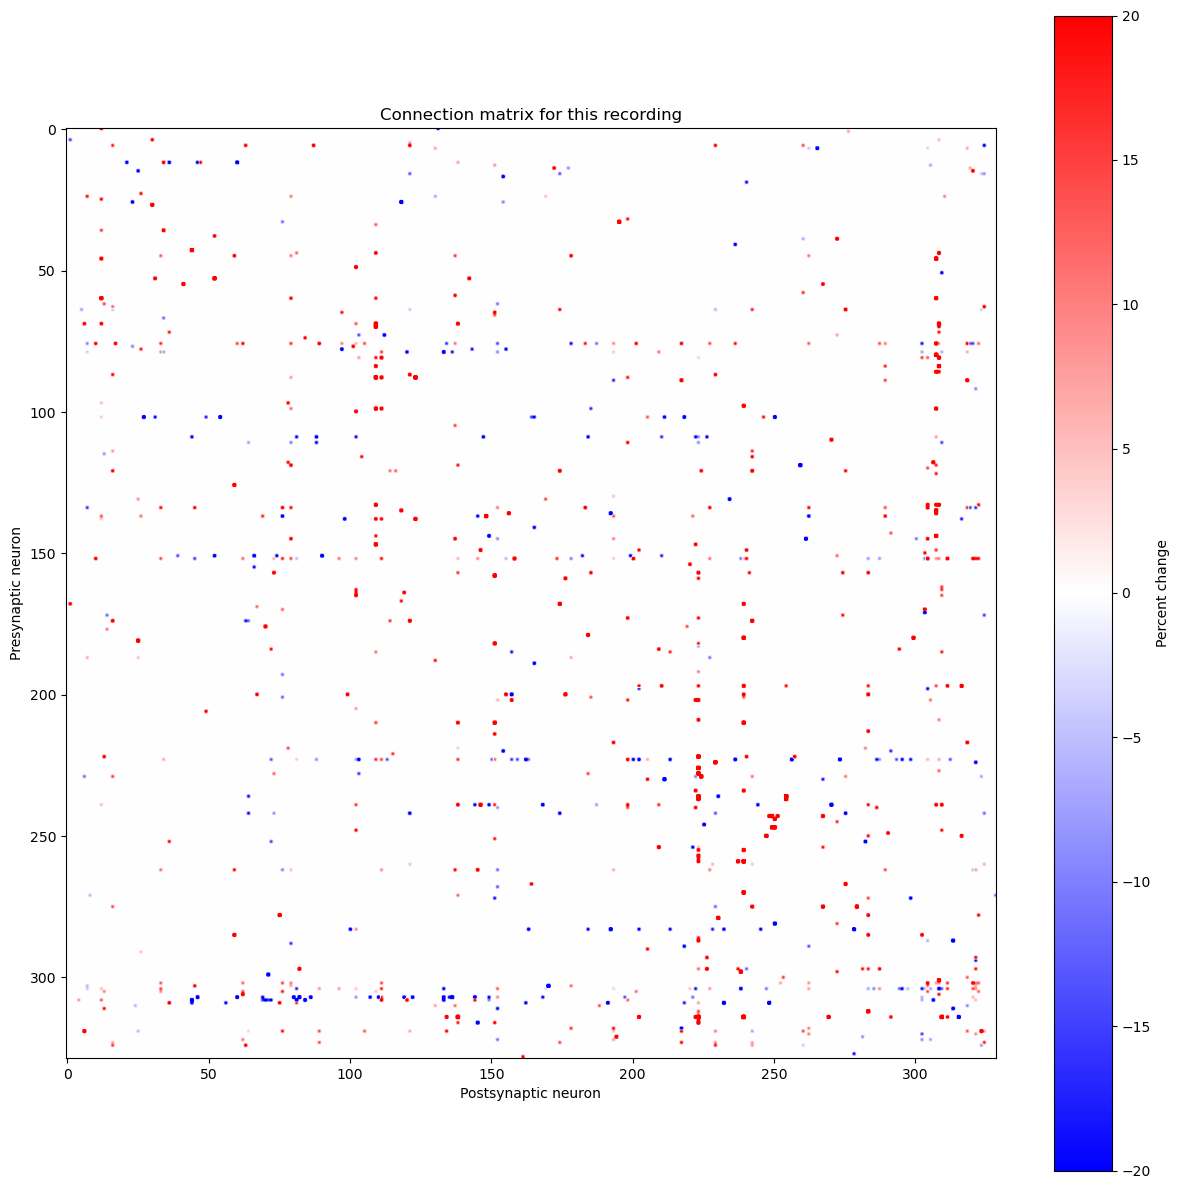

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
imh = ax.imshow(conn_mat.values,cmap='bwr', vmin=-20, vmax=20)
fig.colorbar(imh, label='Percent change')
ax.set_xlabel('Postsynaptic neuron')
ax.set_ylabel('Presynaptic neuron')
ax.set_title('Connection matrix for this recording')
ax.set_aspect('equal')
plt.show()

### Bring in unit properties and add them to pair dataframe

,halfwidth,firing_rate,peak,x,y,unit_type
cluster_id,,,,,,
1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
2,0.233333,5.659228,-23.013167,27.0,3255.0,RS
5,0.233333,0.105429,-25.890844,309.0,3240.0,RS
6,0.236667,0.234809,-29.162822,309.0,3255.0,RS
8,0.143333,9.919040,-25.496567,277.0,3225.0,FS
...,...,...,...,...,...,...
761,0.116667,10.637017,-19.652656,527.0,3300.0,FS
763,0.136667,17.179659,-21.245256,527.0,3615.0,FS
764,0.093333,10.124531,-25.581856,809.0,3630.0,FS


In [23]:
sig_df

,w,cc
pair,,
"(754, 598)",418.537859,"[0.7373272935840243, 0.7472911759297544, 0.827..."
"(562, 554)",306.616990,"[1.2544227571469853, 1.2888314910937717, 1.320..."
"(754, 356)",277.287762,"[0.9087535068446069, 0.804739551241911, 0.8156..."
"(590, 624)",240.789474,"[1.4871484369632368, 1.159100987633111, 1.1809..."
"(754, 748)",225.363825,"[1.7083848910019743, 1.7358288249939737, 1.598..."
...,...,...
"(754, 755)",-76.785714,"[3.670438339626864, 3.0281116301921625, 2.3857..."
"(598, 656)",-80.835381,"[1.8342430898637614, 1.6890321785828801, 1.796..."
"(565, 527)",-86.206897,"[0.749513057021262, 0.7182833463120428, 0.8744..."
